# This notebook submits results to the DPhi challenge: https://dphi.tech/challenges/data-sprint-96-anuran-call-classification/305/overview/about

# Methodology:
1.

### Import all libraries required

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score as acc, classification_report as cr, ConfusionMatrixDisplay as cm
from sklearn.metrics import precision_score as ps, recall_score as rs, f1_score as f1
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb

### Declare the path

In [2]:
train_path = '/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/data/train_dataset.csv'
test_path = '/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/data/test_dataset.csv'

### Read the csv datasets into pandas dataframes

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
display(train_df.head(1))
display(test_df.head(1))

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus
0,1.0,0.119781,0.295089,0.329479,0.179924,0.178956,0.127519,-0.132204,-0.063171,0.097205,0.060323,0.047231,0.108835,-0.017131,-0.125876,0.028727,0.11771,0.03834,0.022927,0.013547,-0.057234,-0.020226,Hypsiboas


,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.315318,0.497602,0.348497,-0.227228,0.287298,0.417227,-0.111509,-0.155905,0.155239,0.021855,-0.114639,0.157684,0.180256,-0.069517,-0.13133,0.072044,0.037927,-0.03158,0.040856,0.142173,-0.02547


In [4]:
d = {value: idx for idx, value in enumerate(train_df.Genus.unique())}
d

{'Hypsiboas': 0,
 'Leptodactylus': 1,
 'Ameerega': 2,
 'Adenomera': 3,
 'Osteocephalus': 4,
 'Dendropsophus': 5,
 'Rhinella': 6,
 'Scinax': 7}

In [5]:
d_rev = {value:key for key, value in d.items()}
d_rev

{0: 'Hypsiboas',
 1: 'Leptodactylus',
 2: 'Ameerega',
 3: 'Adenomera',
 4: 'Osteocephalus',
 5: 'Dendropsophus',
 6: 'Rhinella',
 7: 'Scinax'}

In [6]:
train_df['Genus'] = train_df['Genus'].map(d)

In [7]:
train_df.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus
count,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000,1676.000000
mean,0.986229,0.324950,0.347724,0.385029,0.106248,0.139614,0.040386,-0.023867,0.078227,0.059941,-0.058633,0.019475,0.082730,0.002130,-0.035238,0.008040,0.028524,0.011529,-0.013808,-0.018478,0.017621,0.031685,2.238663
std,0.082463,0.238597,0.301678,0.160415,0.184099,0.128277,0.171155,0.131537,0.168221,0.146964,0.165147,0.167785,0.193987,0.155280,0.176168,0.115847,0.137273,0.078171,0.081785,0.091232,0.077361,0.116135,1.970913
min,-0.251179,-0.591520,-0.397932,-0.162617,-0.434950,-0.346075,-0.452555,-0.576506,-0.454282,-0.497360,-0.901989,-0.600000,-0.606490,-0.421427,-0.438884,-0.461007,-0.405825,-0.475986,-0.471597,-0.326972,-0.229310,-0.350161,0.000000
25%,1.000000,0.169652,0.141529,0.280972,-0.004733,0.044786,-0.093328,-0.125582,-0.043273,-0.001168,-0.179152,-0.077239,-0.052157,-0.092763,-0.165590,-0.064875,-0.090990,-0.029581,-0.064427,-0.075232,-0.034770,-0.038119,0.000000
50%,1.000000,0.305196,0.319707,0.376827,0.134128,0.142072,0.035249,-0.022280,0.094330,0.073603,-0.053264,0.025963,0.074095,-0.017139,-0.048642,0.015390,0.034173,0.011834,-0.006237,-0.016632,0.007412,0.019257,2.000000
75%,1.000000,0.471846,0.545007,0.505353,0.217547,0.219395,0.121465,0.061985,0.210756,0.137862,0.058983,0.100422,0.235666,0.103171,0.110211,0.070823,0.126740,0.056077,0.031336,0.031510,0.064155,0.116609,3.000000
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,0.664746,0.520603,0.738033,0.478224,0.438883,0.639017,0.751285,0.566873,0.661947,0.427408,0.432527,0.614064,0.388499,0.467831,0.294569,0.293917,7.000000


In [8]:
train_df.shape, test_df.shape

((1676, 23), (1676, 22))

# Check duplicate rows

In [9]:
train_df[train_df.duplicated()]

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus


# Visualize the data

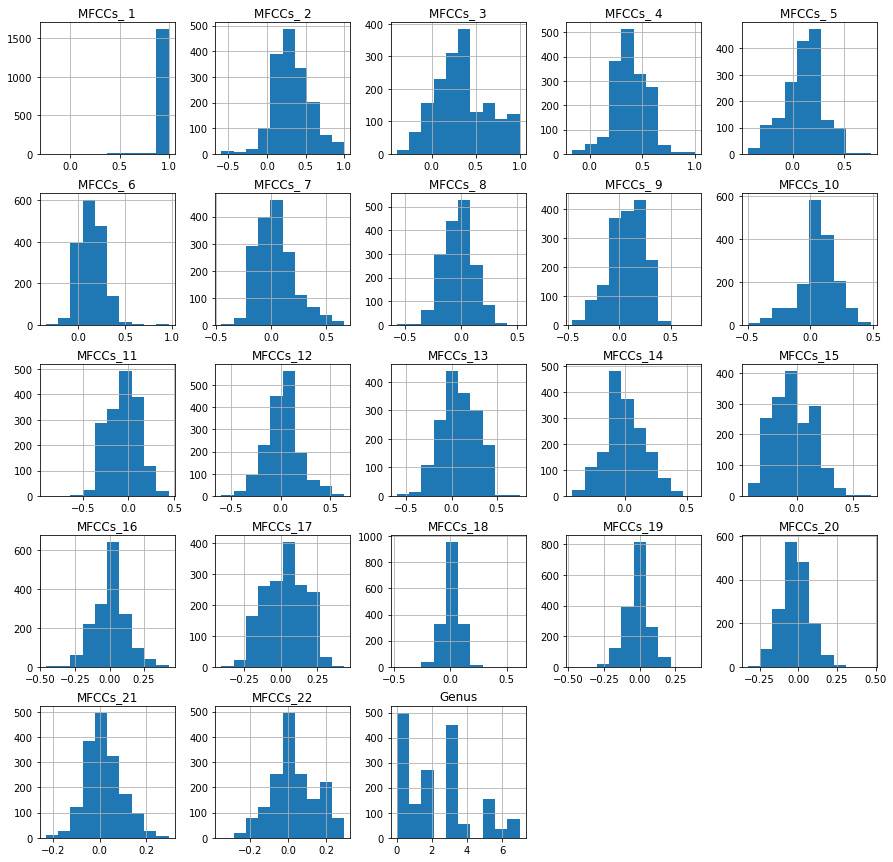

In [12]:
train_df.hist(figsize=(15,15))
plt.show()

# Separate into dependent and independent features

In [13]:
train_X = train_df.drop('Genus', axis=1).copy()
train_y = train_df['Genus'].copy()
final_X = test_df.copy()

# Train Test Split

In [16]:
train_y = train_y.to_numpy()
train_X = train_X.to_numpy()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=1, stratify=train_y)

# Cross Validation for model selection

# Define the models for classification

In [27]:
models = {
#     'LOG': LogisticRegression(max_iter=500, solver='liblinear'),
         'LDA': LinearDiscriminantAnalysis(),
         'KNN': KNeighborsClassifier(n_jobs=4),
         'GNB': GaussianNB(),
         'DCT': DecisionTreeClassifier(),
         'SVM': SVC(),
          'RFC': RandomForestClassifier(n_jobs=4),
          'ADA': AdaBoostClassifier(),
         'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4),
        }

# Evaluate each model in turn using cross validation score on the training data. Metrics: Accuracy, Precision, Recall, F1 Score

In [28]:
for name, model in models.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"{name}: Acc: {cv_results['test_score'].mean():.3f}")

LDA: Acc: 0.903
KNN: Acc: 0.957
GNB: Acc: 0.812
DCT: Acc: 0.873
SVM: Acc: 0.940
RFC: Acc: 0.950
ADA: Acc: 0.574
XGB: Acc: 0.945


# Balance the classes

In [74]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)

In [75]:
weights

array([0.419     , 1.55185185, 0.77306273, 0.46555556, 3.6754386 ,
       1.3516129 , 6.16176471, 2.83108108])

In [76]:
weights = {i:weights[i] for i in range(len(weights))}
weights

{0: 0.419,
 1: 1.5518518518518518,
 2: 0.7730627306273062,
 3: 0.46555555555555556,
 4: 3.675438596491228,
 5: 1.3516129032258064,
 6: 6.161764705882353,
 7: 2.831081081081081}

# KNN

In [298]:
model = KNeighborsClassifier(n_neighbors=3,
    algorithm='auto',
    weights='distance',
    p=1,
    metric='minkowski',
    metric_params=None,
    n_jobs=4)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(acc(y_test, preds))

0.9737470167064439


In [299]:
test_df['Genus'] = model.predict(final_X.iloc[:,:22])
test_df['Genus'] = test_df['Genus'].map(d_rev)
test_df['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub7.csv', 
                   index=False)
test_df['Genus']

0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4           Hypsiboas
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [43]:
model = SVC(C=8,
    kernel='rbf',
    degree=4,
    gamma='scale',
    tol=0.0001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=1,)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(acc(y_test, preds))

0.9904534606205251


In [35]:
len(final_X.columns)

22

In [135]:
test_df['Genus'] = model.predict(final_X.iloc[:,:22])
test_df['Genus'] = test_df['Genus'].map(d_rev)
test_df['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub3.csv', 
                   index=False)
test_df['Genus']

0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4           Hypsiboas
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [242]:
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=1) #Stratified
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    model_svc = SVC(C=8, kernel='rbf', degree=4, gamma='scale', tol=0.2,
    class_weight=None, decision_function_shape='ovr', break_ties=True)
    model_svc.fit(train_X[train_id], train_y[train_id])
    preds_svc = model_svc.predict(train_X[test_id])
    a = acc(train_y[test_id], preds_svc)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Fold:1, Acc: 0.9875
Fold:2, Acc: 0.9750
Fold:3, Acc: 0.9708
Fold:4, Acc: 0.9791
Fold:5, Acc: 0.9707
Fold:6, Acc: 0.9958
Fold:7, Acc: 0.9749
Final: Acc: 0.9791


### Split-5,K-poly,D-4, T-0.05, W-None,C-5, 0.9749, stratified
### Split-5,K-poly,D-4, T-0.05, W-None,C-8, 0.9779, not stratified
### Split-7, K-rbf, T-0.2, C-9, W-None, 0.9791
### Split-5, K-rbf, T-0.1, C-11, W-w, 0.9755

In [245]:
model_svc = SVC(C=9, kernel='rbf', degree=4, gamma='scale', tol=0.2,
    class_weight=None, decision_function_shape='ovr', break_ties=False)
model_svc.fit(train_X, train_y)

SVC(C=9, degree=4, tol=0.2)

In [244]:
test_df['Genus'] = model_svc.predict(final_X.iloc[:,:22])
test_df['Genus'] = test_df['Genus'].map(d_rev)
test_df['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub12.csv', 
                   index=False)
test_df['Genus']

/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4           Hypsiboas
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [254]:
test_df['a'] = model_svc.predict(final_X.iloc[:,:22])
# test_df['a'] = test_df['a'].map(d_rev)

/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# LGBM

In [228]:
# X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=1)
hyper_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'classification', 
                'learning_rate': 0.1, 'n_estimators':10000,'verbose': -1, 
                'random_state':1, 'max_depth': -1, 'colsample_bytree': 0.9, 'num_leaves': 64, 
                'max_bin': 128, }
stopper = lgb.early_stopping(stopping_rounds=100)
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    gbm = lgb.LGBMClassifier(**hyper_params) 
    gbm.fit(train_X[train_id], train_y[train_id], eval_set=[(train_X[test_id], train_y[test_id])], callbacks=[stopper],verbose='warn')
    preds_gbm = gbm.predict(train_X[test_id], num_iteration=gbm.best_iteration_)
    a = acc(train_y[test_id], preds_gbm)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.145476
Fold:1, Acc: 0.9673
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.145476
Fold:2, Acc: 0.9522
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.145436
Fold:3, Acc: 0.9552
Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 0.145436
Fold:4, Acc: 0.9552
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.0822009
Fold:5, Acc: 0.9791
Final: Acc: 0.9618


### Final: Acc: 0.9618 LR-0.1

In [247]:
hyper_params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'classification', 
                'learning_rate': 0.1, 'n_estimators':10000,'verbose': -1, 
                'random_state':1, 'max_depth': -1, 'colsample_bytree': 0.9, 'num_leaves': 64, 
                'max_bin': 128, }
gbm = lgb.LGBMClassifier(**hyper_params) 
gbm.fit(train_X, train_y, verbose='warn')

LGBMClassifier(colsample_bytree=0.9, max_bin=128, n_estimators=10000,
               num_leaves=64, objective='classification', random_state=1,
               task='train', verbose=-1)

In [231]:
test_df['Genus'] = gbm.predict(final_X.iloc[:,:22])
test_df['Genus'] = test_df['Genus'].map(d_rev)
test_df['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub6.csv', 
                   index=False)
test_df['Genus']

0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4           Hypsiboas
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [255]:
test_df['b'] = gbm.predict(final_X.iloc[:,:22])
# test_df['b'] = test_df['b'].map(d_rev)

# XGB Classifier

In [209]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, random_state=1,
            n_estimators=100, max_depth=15, learning_rate=0.3, booster='gbtree', num_parallel_tree=1,
            colsample_bytree=0.9, colsample_bylevel=1, colsample_bynode=1, )
    model_xgb.fit(train_X[train_id], train_y[train_id])
    preds_xgb = model_xgb.predict(train_X[test_id])
    a = acc(train_y[test_id], preds_xgb)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Fold:1, Acc: 0.9643
Fold:2, Acc: 0.9552
Fold:3, Acc: 0.9552
Fold:4, Acc: 0.9552
Fold:5, Acc: 0.9821
Final: Acc: 0.9624


### Final: Acc: 0.9624 LR-0.3

In [249]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, random_state=1,
            n_estimators=100, max_depth=15, learning_rate=0.3, booster='gbtree', num_parallel_tree=1,
            colsample_bytree=0.9, colsample_bylevel=1, colsample_bynode=1,
                         )
model_xgb.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, eval_metric='logloss', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [211]:
final_X['Genus'] = model_xgb.predict(final_X.iloc[:,:22])
final_X['Genus'] = final_X['Genus'].map(d_rev)
final_X['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub5.csv', 
                   index=False)
final_X['Genus']

0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4           Hypsiboas
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [256]:
test_df['c'] = model_xgb.predict(final_X.iloc[:,:22])
# test_df['c'] = test_df['c'].map(d_rev)

In [258]:
test_df.head(50)

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus,a,b,c
0,1.000000,0.315318,0.497602,0.348497,-0.227228,0.287298,0.417227,-0.111509,-0.155905,0.155239,0.021855,-0.114639,0.157684,0.180256,-0.069517,-0.131330,0.072044,0.037927,-0.031580,0.040856,0.142173,-0.025470,Leptodactylus,1,1,1
1,1.000000,0.756413,0.732319,0.385807,-0.034821,0.073881,-0.058027,0.183775,0.219419,-0.445112,-0.183236,0.400255,-0.177708,-0.311815,0.182382,0.030100,-0.182019,0.006296,-0.005868,0.029439,0.004783,-0.198014,Hypsiboas,0,0,0
2,1.000000,0.415183,0.335966,0.475031,0.090405,0.005044,-0.039698,0.084663,0.240898,-0.051561,-0.326613,0.143170,0.380234,-0.107244,-0.230384,0.138169,0.173223,-0.079970,-0.115304,-0.044019,0.123564,0.165076,Adenomera,3,3,3
3,1.000000,0.338689,-0.064142,-0.041990,-0.033732,0.269438,0.497481,0.205565,-0.204474,-0.243321,-0.081751,-0.017808,0.129518,0.341234,0.147532,-0.208999,-0.193580,-0.021241,-0.027304,0.007022,0.152431,0.128729,Ameerega,2,2,2
4,1.000000,0.703540,0.613362,0.410972,-0.031303,0.159498,0.210965,-0.082156,-0.004225,0.156324,-0.042319,-0.025046,0.180426,0.088834,-0.091483,0.028710,0.138252,0.011317,-0.025057,0.133431,0.018059,-0.074689,Hypsiboas,0,0,0
5,1.000000,0.172276,0.347315,0.316618,0.166668,0.172580,0.118242,-0.141640,-0.056477,0.094137,0.052445,0.038944,0.093547,-0.042472,-0.118637,0.043542,0.102702,0.045390,0.021516,-0.019555,-0.046689,0.020165,Hypsiboas,0,0,0
6,1.000000,0.314321,0.438354,0.312396,-0.059697,0.230965,0.162220,-0.013198,0.139567,-0.037269,-0.285136,0.239512,0.443874,-0.121170,-0.161056,0.104761,0.007516,-0.116001,0.044513,0.061379,-0.005701,-0.029319,Leptodactylus,1,1,1
7,1.000000,0.436775,0.290452,0.582707,0.151380,0.000139,-0.145080,0.080229,0.292180,0.007001,-0.337588,0.034537,0.349136,-0.120689,-0.228393,0.079014,0.219721,0.102192,-0.041079,-0.144267,0.047870,0.222136,Adenomera,3,3,3
8,1.000000,0.055524,0.178132,0.267639,0.335619,0.150990,-0.161144,-0.034555,0.053430,0.076487,0.066650,0.019206,-0.013348,-0.058639,-0.016095,0.076258,0.037511,0.008081,-0.018888,-0.012897,0.000089,0.015588,Scinax,7,7,7
9,0.873996,0.728603,1.000000,0.526201,-0.321300,0.363206,0.162015,-0.144536,-0.007577,-0.207600,-0.103665,0.251998,-0.046625,-0.129701,0.269362,0.139610,-0.039627,-0.039096,-0.005519,0.150876,0.093162,-0.119576,Hypsiboas,0,0,0


In [253]:
test_df['d'] = max(test_df['a'],test_df['b'],test_df['c'])
test_df

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# RF Classifier

In [139]:
train_y = train_y.to_numpy()
train_X = train_X.to_numpy()

In [177]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold=0
res = {'Acc':[]}
for train_id, test_id in kfold.split(train_X, train_y):
    fold+=1
    model_rfc = RandomForestClassifier(n_jobs=4, random_state=1,
        n_estimators=100, criterion='gini',  max_depth=12, max_features=0.6, class_weight=weights)
    model_rfc.fit(train_X[train_id], train_y[train_id])
    preds_rfc = model_rfc.predict(train_X[test_id])
    a = acc(train_y[test_id], preds_rfc)
    print(f'Fold:{fold}, Acc: {a:0.4f}')
    res['Acc'].append(a)
print(f"Final: Acc: {np.array(res['Acc']).mean():0.4f}")

Fold:1, Acc: 0.9583
Fold:2, Acc: 0.9403
Fold:3, Acc: 0.9672
Fold:4, Acc: 0.9493
Fold:5, Acc: 0.9642
Final: Acc: 0.9558


### Final: Acc: 0.9558 MD-12

In [178]:
model_rfc = RandomForestClassifier(n_jobs=4, random_state=1,
        n_estimators=100, criterion='gini',  max_depth=12, max_features=0.6, class_weight=weights)
model_rfc.fit(train_X, train_y)

RandomForestClassifier(class_weight={0: 0.419, 1: 1.5518518518518518,
                                     2: 0.7730627306273062,
                                     3: 0.46555555555555556,
                                     4: 3.675438596491228,
                                     5: 1.3516129032258064,
                                     6: 6.161764705882353,
                                     7: 2.831081081081081},
                       max_depth=12, max_features=0.6, n_jobs=4,
                       random_state=1)

In [179]:
final_X['Genus'] = model_rfc.predict(final_X.iloc[:,:22])
final_X['Genus'] = final_X['Genus'].map(d_rev)
final_X['Genus'].to_csv('/home/sandeep/Development/Datasets/Nature/dphi_ds96_Anuran_Call_Classification/submission/sub4.csv', 
                   index=False)
final_X['Genus']

/home/sandeep/anaconda3/envs/my_env1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0       Leptodactylus
1           Hypsiboas
2           Adenomera
3            Ameerega
4       Leptodactylus
            ...      
1671    Dendropsophus
1672    Dendropsophus
1673         Ameerega
1674        Hypsiboas
1675    Dendropsophus
Name: Genus, Length: 1676, dtype: object

In [263]:
train_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Genus
0,1.0,0.119781,0.295089,0.329479,0.179924,0.178956,0.127519,-0.132204,-0.063171,0.097205,0.060323,0.047231,0.108835,-0.017131,-0.125876,0.028727,0.117710,0.038340,0.022927,0.013547,-0.057234,-0.020226,0
1,1.0,0.653562,0.924797,0.375699,0.298197,-0.032417,0.020878,0.003379,0.205143,0.078281,0.107944,0.145618,0.017197,-0.043285,0.023934,0.083198,0.061530,-0.005929,0.001438,0.084545,0.087731,0.027106,0
2,1.0,0.060299,0.324429,0.411001,0.209832,0.185888,0.114315,-0.162366,-0.049923,0.103734,0.070839,0.023101,0.107238,-0.005294,-0.089390,-0.002942,0.095505,0.032248,0.026255,0.011327,-0.073650,-0.027495,0
3,1.0,0.318058,0.802882,0.322736,-0.314240,0.347878,0.337821,-0.189927,-0.019588,0.204428,-0.045410,-0.079590,0.203352,0.098808,-0.123705,-0.036430,0.082222,-0.005785,-0.041194,0.021666,0.092925,-0.000002,1
4,1.0,0.470661,0.301141,0.384953,0.063172,0.029145,0.140112,0.021464,-0.170095,-0.010733,0.185600,-0.058667,-0.223039,0.104809,0.110101,-0.148516,-0.121830,0.128067,0.076941,-0.019640,-0.017236,-0.015215,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,1.0,0.382833,0.360921,0.232074,0.087044,0.189804,0.028478,-0.076736,0.053469,0.101426,-0.030383,0.058928,0.083143,-0.062311,-0.052768,0.072156,0.058050,-0.002515,-0.032716,-0.038140,0.010632,0.070336,0
1672,1.0,0.197632,0.206213,0.514548,0.162146,0.039368,-0.057877,0.055382,0.206964,-0.000199,-0.155478,0.209233,0.229430,-0.275690,-0.198213,0.235286,0.196981,-0.077365,-0.147423,-0.065556,0.164076,0.187205,3
1673,1.0,0.287829,0.680899,0.309173,-0.305079,0.332896,0.416649,-0.213375,-0.087615,0.181985,-0.132165,-0.086598,0.260390,0.107244,-0.149598,-0.041556,0.101155,0.043391,0.013300,0.080039,0.105382,-0.022527,1
1674,1.0,0.101645,0.143823,0.560305,0.251343,0.080044,-0.112337,-0.010153,0.181004,0.023495,-0.132027,0.235160,0.249772,-0.251070,-0.197646,0.303148,0.256516,-0.100701,-0.180266,-0.073157,0.215374,0.254988,3


<AxesSubplot:xlabel='Genus', ylabel='MFCCs_14'>

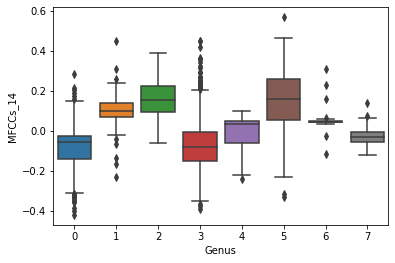

In [282]:
sns.boxplot(data=train_df, x='Genus', y='MFCCs_14')

In [276]:
a = train_df.describe().transpose()
type(a)

pandas.core.frame.DataFrame

In [278]:
a['ratio'] = a['std']/a['mean']
a

,count,mean,std,min,25%,50%,75%,max,ratio
MFCCs_ 1,1676.0,0.986229,0.082463,-0.251179,1.000000,1.000000,1.000000,1.000000,0.083614
MFCCs_ 2,1676.0,0.324950,0.238597,-0.591520,0.169652,0.305196,0.471846,1.000000,0.734256
MFCCs_ 3,1676.0,0.347724,0.301678,-0.397932,0.141529,0.319707,0.545007,1.000000,0.867578
MFCCs_ 4,1676.0,0.385029,0.160415,-0.162617,0.280972,0.376827,0.505353,1.000000,0.416631
MFCCs_ 5,1676.0,0.106248,0.184099,-0.434950,-0.004733,0.134128,0.217547,0.752246,1.732733
MFCCs_ 6,1676.0,0.139614,0.128277,-0.346075,0.044786,0.142072,0.219395,0.964240,0.918794
MFCCs_ 7,1676.0,0.040386,0.171155,-0.452555,-0.093328,0.035249,0.121465,0.664746,4.237981
MFCCs_ 8,1676.0,-0.023867,0.131537,-0.576506,-0.125582,-0.022280,0.061985,0.520603,-5.511224
MFCCs_ 9,1676.0,0.078227,0.168221,-0.454282,-0.043273,0.094330,0.210756,0.738033,2.150429
MFCCs_10,1676.0,0.059941,0.146964,-0.497360,-0.001168,0.073603,0.137862,0.478224,2.451803


In [280]:
a.sort_values(by='ratio', ascending=False)

,count,mean,std,min,25%,50%,75%,max,ratio
MFCCs_14,1676.0,0.002130,0.155280,-0.421427,-0.092763,-0.017139,0.103171,0.566873,72.910619
MFCCs_16,1676.0,0.008040,0.115847,-0.461007,-0.064875,0.015390,0.070823,0.427408,14.409195
MFCCs_12,1676.0,0.019475,0.167785,-0.600000,-0.077239,0.025963,0.100422,0.639017,8.615548
MFCCs_18,1676.0,0.011529,0.078171,-0.475986,-0.029581,0.011834,0.056077,0.614064,6.780452
MFCCs_17,1676.0,0.028524,0.137273,-0.405825,-0.090990,0.034173,0.126740,0.432527,4.812596
MFCCs_21,1676.0,0.017621,0.077361,-0.229310,-0.034770,0.007412,0.064155,0.294569,4.390390
MFCCs_ 7,1676.0,0.040386,0.171155,-0.452555,-0.093328,0.035249,0.121465,0.664746,4.237981
MFCCs_22,1676.0,0.031685,0.116135,-0.350161,-0.038119,0.019257,0.116609,0.293917,3.665234
MFCCs_10,1676.0,0.059941,0.146964,-0.497360,-0.001168,0.073603,0.137862,0.478224,2.451803
MFCCs_13,1676.0,0.082730,0.193987,-0.606490,-0.052157,0.074095,0.235666,0.751285,2.344820
